In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.transform import radon,rescale,rotate 
from scipy.interpolate import RectBivariateSpline

### 1 Faça o plot do sinograma, rotulando devidamente os eixos:

O objetivo desse trabalho é através de um sinograma fornecido conseguir obter a imagem que o gerou através de uma retroprojeção e uma retroprojeção filtrada. A ideia principal do CT Scan e de utilizar a interação da radiação eletromagnética com a matéria para desenhar uma imagem que represente ao objeto em questão, com auxilio de um detetor realiza-se um varrimento sobre o objeto, medindo a atenuação da luz em relação com a potencia de quando é emitida pela fonte. Com isso se cria um conjuntos de dados com a informação da potencia da luz ao chegar no detetor e qual foi a angulação desse ponto, coletando essas informações consegue-se definir uma função que da origem ao sinograma  $p(s,\phi)$.

O primeiro passo dessa atividade é converter a imagem Sinograma1 para um array e após com essa informação construir um gráfico com os eixos rotulados. Para isso se utiliza a função open do pacote Image, com essa informação possibilita a criação de um array 2D (se retira a terceira dimensão que representa o código RGB da imagem para a realização do TPC). Ao construir o gráfico se define um mapa de valores, utilizando a função meshgrid, para a posição relativa no detetor (s) e o angulo da medição do detetor em relação a fonte($\phi$) escolhendo os intervalos $-1\leq s\leq 1$ e $0\leq \phi\leq \pi$.

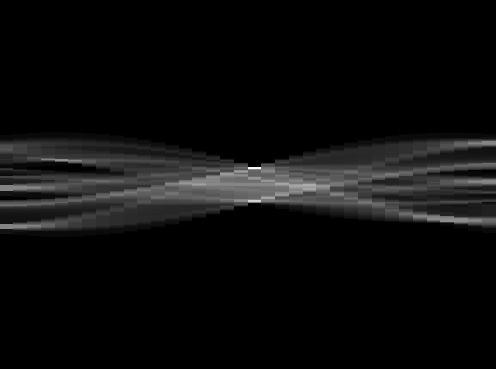



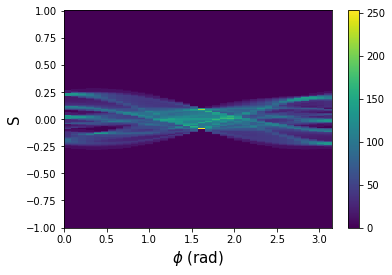

In [2]:
sino = Image.open('sinograma1.png')
sino = np.array(sino)[:,:,0]

phis, rs =  np.linspace(0,np.pi,sino.shape[1]),np.linspace(-1,1,sino.shape[0])
phisv , rsv = np.meshgrid(phis,rs)

plt.pcolormesh(phisv,rsv,sino)
plt.ylabel('S',size =15)
plt.xlabel(r'$\phi$ (rad)',size=15)
plt.colorbar()

Com o código acima se obteve:

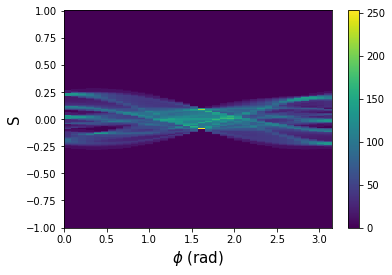

 ### 2  Faça a retroprojecção, usando a rotina que desenvolveu nas aulas PL. Faça o plot da imagem resultante:
 
 Para conseguir construir uma imagem através das informações fornecidas pelo sinograma se utiliza a tranformada de Radon, na qual consiste em obter $f(x,y)$ a partir do $p(s,\phi)$ na aproximção:
 
 $$
 f(x,y) \approx \sum p(x \cos(\phi)+y\sin(\phi),\phi)\Delta\phi
 $$
 
 Como queremos projetar nossa imagem numa grade quadricular, para isso utilizamos a função do scipy chamada RectBivariateSpline que aproxima nossos valores que estão definidos em cordenadas polares para cilindricas. Para a construção do grafíco cria um mapa com valores de x e y definidos nos intervalos $[-0.5,0.5]$ que irão receber os valores obtidos com a transformada de Radon. 

In [3]:
def mapa(sinograma,intervalo):
    xs = np.linspace(-intervalo,intervalo,sinograma.shape[1])
    ys = np.linspace(-intervalo,intervalo,sinograma.shape[0])
    xv,yv = np.meshgrid(xs,ys)
    return xv,yv

interpolar = RectBivariateSpline(rs,phis,sino)
dphi = phis[1]-phis[0]

def RetroProjecao(x,y):
    return interpolar(x*np.cos(phis)+y*np.sin(phis),phis,grid=False).sum()*dphi 

xv,yv = mapa(sino,0.5)
Imagem = np.vectorize(RetroProjecao)(xv,yv)


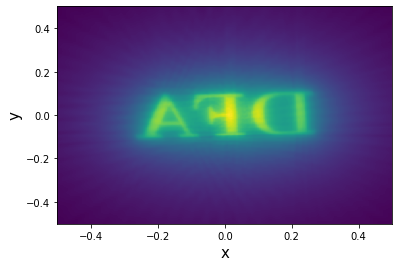

In [4]:
plt.pcolormesh(xv,yv,Imagem)
plt.ylabel('y',size =15)
plt.xlabel('x',size=15)
plt.show()

Como resultado se obteve uma imagem que pode-se definir o objeto, porém apresenta uma forma esborratada pelo fato de como é feito a retroprojeção. Ao realizar  uma aproximação através duma interpolação os pixéis não conseguem tem definição limitada devido  a sobreposição de valores perto da origem do detetor. Resultado que impulsiona a procura de um outro método que consiga fornecer essa definição,  apresentada na próxima questão. 

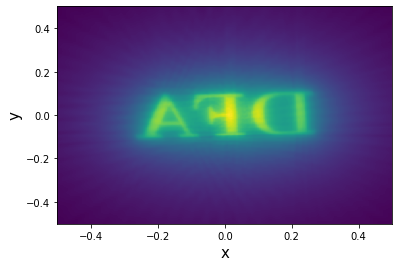

### 3  Faça a retroprojecção filtrada, de novo com a rotina que desenvolveu nas aulas PL para esse efeito. Faça o plot da imagem resultante:

Para aumentar a resolução da imagem recuperada através do sinograma, baseia-se no Teorema da Fatia Central na qual afirma a possibilidade de criar uma relação entre a projeção de uma função 2D $f(x,y)$ com uma fatia que passa pela origem  da função paralela a projeção, isso no espaço das frequências. Com essa informação e sabendo que os limites do domínio é responsabilidade das altas frequências, inspira utilizar um filtro passa alto para obter melhor definição da imagem.

Para realizar essa operação primeiro realiza a transformada de Fourier do sinograma que ira ser multiplicada depois pelo filtro e a transformada inversa do resultado ira dar origem nos pontos que serão utilizados para reconstrução da imagem. Na construção do filtro se utiliza a função fftfreq que ira devolver os coeficientes de Fourier  para nosso sinograma, os argumentos  devolvem o tamanho do array e o espaçamento entre as frequências. 

Para construir a imagem se utiliza a transposta para que se possa realizar a multiplicação de matrizes, após obter o resultado da multiplicação, antes de realizar a reconstrução tem que ter o cuidado de realizar a interpolação para uma grelha cilíndrica, já que o resultado é apresentado em uma grelha polar. Com isso o procedimento é o mesmo que o realizado na retroprojeção, obtendo o seguinte resultado:

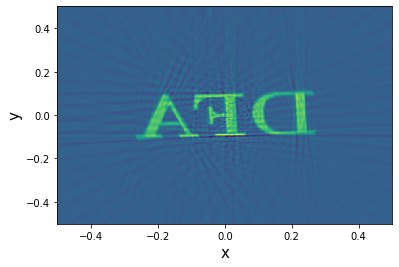

In [6]:
def FiltroRetProj(sinograma):
    Fsino = np.fft.fft(sinograma,axis=0)
    filtro = np.abs(np.fft.fftfreq(sinograma.shape[0],d = np.diff(rs)[0]))
    Dados = Fsino.T*filtro
    return np.real(np.fft.ifft(Dados.T,axis = 0))
    
                   
Pw = FiltroRetProj(sino)
Pw_interpolacao = RectBivariateSpline(rs,phis,Pw)   
dphi = phis[1]-phis[0]
                   
def RetroProjFiltro(x,y):
    return Pw_interpolacao(x*np.cos(phis)+y*np.sin(phis),phis,grid=False).sum()*dphi

xv,yv = mapa(sino,0.5)                  
RetroProjF = np.vectorize(RetroProjFiltro)(xv,yv)              

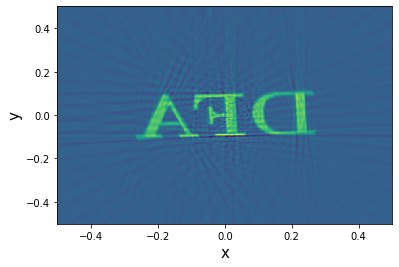

In [7]:
plt.pcolormesh(xv,yv,RetroProjF)
plt.ylabel('y',size =15)
plt.xlabel('x',size=15)
plt.show()